# Reconstruction of Reflectance Spectra
### An example of dimensionality reduction using Principal Component Analysis (PCA)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pca_functions import *

tol = 1e-6

#### Loading Raw Data
Read in CSV file of reflectance spectra for both types of beans recorded using a Fourier-Transform Infrared Spectrometer (FTIR). The first row in the dataset contains the wavelengths at which the reflectances are measured.

In [2]:
# Read in spectra data
dataset = pd.read_csv("FTIR_Spectra_Coffee.csv", header = 0)
spectra = np.array(dataset)
wavelengths = list(dataset.columns.values)

# Get shape of dataset
print("Shape of Spectra Dataset:", spectra.shape)

Shape of Spectra Dataset: (56, 286)


#### Prepare Data for PCA
Center the data as this is one of the key assumptions of PCA as such standardization ensures that all variables are transformed to the same scale. Also find the corresponding empirical covariance matrix to find eigenpairs later (we require a square matrix).

In [3]:
# Center data using pre-defined function
centered = center_matrix(spectra)

# Find empirical covariance matrix using pre-defined function
cov = covariance_matrix(centered)

#### Find Eigenpairs of Covariance Matrix
Calculate eigenvalues and eigenvectors numerically using the Power and Deflate methods.

In [5]:
# Create initial vector to aid with matrix calculations
rows = cov.shape[0]
init_vector = np.ones(rows)

eigvals = []
eigvecs = []
init_mat = cov
# Loop through the spectra and find eigenpairs and store as arrays
for i in range(rows):
    tempval, tempvec = power_method(init_mat, init_vector, tol)
    init_mat = deflate(init_mat, tempval, tempvec)
    eigvals.append(tempval)
    eigvecs.append(tempvec)

In [6]:
eigvals

[-162865.91025533696,
 -5652.7839277727935,
 -3543.178624435294,
 -905.794814526606,
 -536.0917399412679,
 -342.30013021682447,
 -221.647864584894,
 -135.14739705314307,
 -117.84535706682334,
 -103.70257331192525,
 -74.75776088410527,
 -62.330317739984096,
 -55.3951084112015,
 -53.73885233397436,
 -47.06415285327765,
 -44.26179869982653,
 -40.104788907797634,
 -37.01622103604531,
 -33.889727277082486,
 -32.81149012607918,
 -31.601614193693614,
 -28.051578811298178,
 -26.593299823047392,
 -24.805369652468602,
 -22.880740167595917,
 -21.75011298284027,
 -19.912649701936267,
 -18.489211043188146,
 -17.75345933238128,
 -16.992741023805888,
 -15.241539697571268,
 -14.562004433723178,
 -14.342137810931458,
 -13.816038545706807,
 -12.574076051274146,
 -12.13336013449095,
 -11.27364430653314,
 -9.371723159279577,
 -9.296496784127454,
 -8.606682426845792,
 -7.829622965850083,
 -7.50940658500958,
 -7.211220889728879,
 -6.812536502288978,
 -5.997808117443764,
 -5.909864030194398,
 -5.415567650236

#### Examine Explained Variation Using Eigenpairs
Find how much of the original reflectance spectra is captured by its eigenpairs.

In [7]:
# Find total sum of eigenvalues
eigsum = sum(eigvals)

# Find cumulative sum of eigenvalues
eigratio = np.cumsum(eigvals)/eigsum
x = np.array(range(1, len(eigvals) + 1))

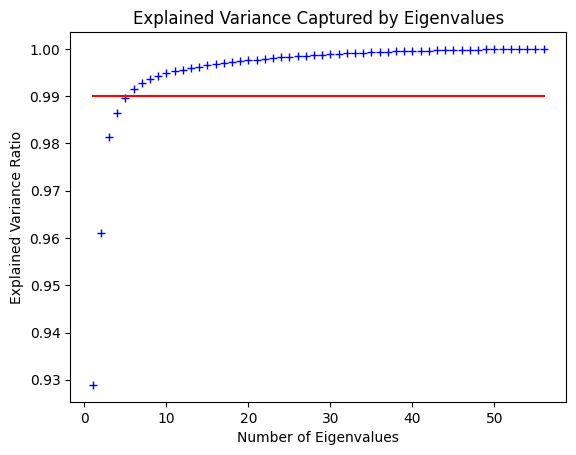

In [8]:
# Plot explained variance
plt.plot(x, eigratio, "b+")
plt.plot(x, [0.99]*len(x), "r-")   # Plot horizontal line for comparison
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Number of Eigenvalues")
plt.title("Explained Variance Captured by Eigenvalues")
plt.show()

In [10]:
# Calculate percentage increase between consecutive points to find the limiting eigenvalue
grads = 100*np.diff(eigratio)/eigratio[:-1]
grads

array([3.47082082e+00, 2.10254337e+00, 5.26435520e-01, 3.09937543e-01,
       1.97286867e-01, 1.27496628e-01, 7.76407061e-02, 6.76483501e-02,
       5.94895347e-02, 4.28596915e-02, 3.57195516e-02, 3.17338653e-02,
       3.07752896e-02, 2.69445151e-02, 2.53333243e-02, 2.29482383e-02,
       2.11760788e-02, 1.93833832e-02, 1.87630437e-02, 1.80677937e-02,
       1.60352120e-02, 1.51991742e-02, 1.41751434e-02, 1.30734518e-02,
       1.24258167e-02, 1.13746625e-02, 1.05603533e-02, 1.01390484e-02,
       9.70361629e-03, 8.70275741e-03, 8.31402644e-03, 8.18781512e-03,
       7.88682337e-03, 7.17728862e-03, 6.92523072e-03, 6.43409415e-03,
       5.34828562e-03, 5.30507146e-03, 4.91116646e-03, 4.46753945e-03,
       4.28463434e-03, 4.11432256e-03, 3.88669545e-03, 3.42174277e-03,
       3.37145541e-03, 3.08936537e-03, 2.87423563e-03, 2.66732427e-03,
       2.10371975e-03, 1.89058876e-03, 1.73619417e-03, 1.65661234e-03,
       1.54295514e-03, 1.17325955e-03, 2.42620491e-07])

Based on the results above, we can use **6** eigenvalues to explain around **99.2%** of the variation in the original spectra.

#### Project Data into Eigenspace
Extract principal components and project the centered data into Eigenspace. We must then find a pair of eigenvectors that allow us to best distinguish between the coffee beans.

In [11]:
np.array(eigvecs)[0:6, :]

array([[-4.78020376e-01,  1.67482369e-01, -1.97338632e-02,
        -1.48652504e-01, -2.38363814e-01,  3.52163864e-02,
        -5.78079202e-02, -1.50614810e-01, -5.17337614e-02,
        -1.34828286e-01, -1.33603717e-01, -1.94083283e-02,
        -2.36104554e-01, -5.13962777e-03, -8.32519510e-03,
         1.96443517e-02,  2.08879876e-02, -9.27565093e-02,
         6.66759778e-02,  2.23504422e-02,  2.12602545e-01,
        -1.79180491e-02,  6.89044475e-02, -4.53913785e-02,
        -4.24815173e-02, -2.43519912e-02,  2.29315562e-01,
         2.15394825e-01,  1.98675097e-02, -2.03642278e-04,
         4.10372450e-02,  1.38123922e-01, -1.72764167e-01,
        -1.03585704e-01,  1.47077438e-01,  6.14338180e-02,
        -1.72483087e-01, -1.24765583e-01,  2.68879502e-02,
         9.16437944e-02,  6.37437711e-02, -1.73750416e-01,
        -6.18478435e-02, -9.13183814e-02, -1.73479382e-02,
         9.03452262e-02, -5.34910502e-03,  1.53831106e-01,
         2.27079909e-01,  1.14993210e-01,  1.36500899e-0

In [13]:
prin.shape

(6, 56)

In [12]:
# Extract 6 principal components
prin = np.array(eigvecs)[0:6, :]

# Find projected matrix using matrix multiplication
projection = np.matmul(centered, prin.transpose())

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 56 is different from 286)

In [ ]:
# Obtain all combinations of columns in the projection matrix 
fig = plt.figure()
k = 1
for i in range(0, 5):
    for j in range(i + 1, 6):
        ax = fig.add_subplot(3, 5, k)
        ax.plot(proj[0:29, j], proj[0:29, i], "r.", label = "Arabica Coffee")
        ax.plot(proj[29:rows, j], proj[29:rows, i], "b.", label = "Robusta Coffee")
        ax.set_ylabel("PC" + str(i + 1), size = 10)
        ax.set_xlabel("PC" + str(j + 1), size = 10)
        k += 1

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc = "upper left", prop = {"size": 9})
fig.suptitle("Comparison of principal Components")
fig.tight_layout(pad = 1.5)
plt.show()

Third and fourth components (scatter plot 10) offer a good separation of coffee beans.

In [ ]:
# Scatter plot 10
plt.plot(proj[0:mid_rows, 3], proj[0:mid_rows, 2], "r.", label = "Arabica Coffee")
plt.plot(proj[mid_rows:rows, 3], proj[mid_rows:rows, 2], "b.", label = "Robusta Coffee")
plt.ylabel("PC3")
plt.xlabel("PC4")
plt.title("Comparison of principal Components 3 and 4")
plt.legend()
plt.show()

Select row 10 (Arabica) and row 39 (Robusta) for reconstruction.

In [ ]:
fig, axs = plt.subplots(2)

#### Generate Reconstructed Spectra
Based on the projected matrix, reconstruct the original spectra using 6 principal components.

In [ ]:
# Arabica
sums = [0]*cols
for i in range(0, 6):
    sums += proj[9, i]*eigvecs[i, 0:cols]

recon_arab = sums + emp_mean
axs[0].plot(spectra[0, :], recon_arab, label = "Reconstruction")
axs[0].plot(spectra[0, :], spectra[10, :], label = "Original")
axs[0].set_ylabel("Reflectance for Arabica")

# Robusta
sums = [0]*cols
for i in range(0, 6):
    sums += proj[38, i]*eigvecs[i, 0:cols]

recon_rob = sums + emp_mean
axs[1].plot(spectra[0, :], recon_rob, label = "Reconstruction")
axs[1].plot(spectra[0, :], spectra[39, :], label = "Original")
axs[1].set_ylabel("Reflectance for Robusta")
axs[1].set_xlabel("Wavelength (nm)")
fig.suptitle("Original and Reconstructed Spectra for Arabica and Robusta Coffees")
plt.legend()
plt.show()